In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

pd.read_csv(
    'history/GSPC_original.csv',
    sep='\t').to_csv('history/GSPC.csv')

In [3]:
leverage_ratio = 3

In [44]:
etf_csv_file = 'history/NDX.csv'
etf_3x_csv_file = 'history/TQQQ.csv'
simulation_result_exls_file = 'TQQQ_simulation.xlsx'

In [4]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}), (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date


date = '9/17/2015'
date = 'Jun 14 2022'
date = 'Apr 01, 1929'

date_normalize(
    date,
    )

'1929-04-01'

In [5]:
def str_to_float(input):
    try:
        return float(re.sub(r'[^\d\.]', r'', input))
    except:
        return input

In [6]:
qqq  = pd.read_csv(
    etf_csv_file,
    )

qqq['Date'] = qqq['Date'].apply(date_normalize)
qqq['Close'] = qqq['Close'].apply(str_to_float)

qqq = pysqldf(u"""
    select *
    from qqq
    order by Date asc
    """)

qqq['id'] = qqq.index

In [7]:
qqq = pysqldf(u"""
    select qqq.*, 
    pre_day.Date as pre_Date,
    pre_day.Close as pre_Close,
    (qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
    from qqq 
    left join qqq as pre_day on pre_day.id+1 = qqq.id
    order by qqq.Date asc
    """)

In [17]:
qqq.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume,id,pre_Date,pre_Close,Percent
9273,2022-07-18,12089.67969,12156.08984,11836.51953,11877.50000,11877.50000,5003870000,9273,2022-07-15,11983.62012,-0.008855
9274,2022-07-19,12046.69043,12258.37012,11967.91992,12249.41992,12249.41992,5251410000,9274,2022-07-18,11877.50000,0.031313
9275,2022-07-20,12269.07031,12488.38965,12232.20020,12439.67969,12439.67969,5427450000,9275,2022-07-19,12249.41992,0.015532


In [18]:
data_list = pysqldf(u"""
    select 
    Date,
    Percent, 
    {}*Percent as Leveraged_Percent
    from qqq
    where Percent is not null
    """.format(leverage_ratio)).to_dict('records')

In [19]:
data_list[0:3]

[{'Date': '1985-10-02',
  'Percent': -0.011726431351225594,
  'Leveraged_Percent': -0.035179294053676785},
 {'Date': '1985-10-03',
  'Percent': 0.00040609971773787433,
  'Leveraged_Percent': 0.001218299153213623},
 {'Date': '1985-10-04',
  'Percent': -0.007170614038857749,
  'Leveraged_Percent': -0.021511842116573247}]

In [21]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

<AxesSubplot:xlabel='Date'>

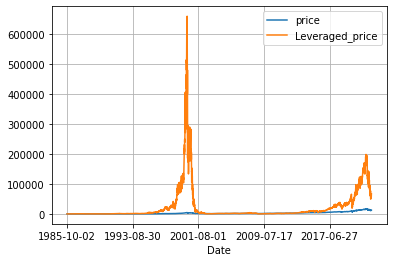

In [22]:
data1.plot(x ='Date', y=[
    'price', 
    'Leveraged_price',
    ], grid = True)

tqqq vs 3x qqq

In [30]:
data_3x  = pd.read_csv(
    etf_3x_csv_file,
    )

data_3x.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-11,0.406875,0.434896,0.405573,0.432552,0.431471,3456000
1,2010-02-12,0.420781,0.438073,0.418333,0.434323,0.433238,8601600
2,2010-02-16,0.444531,0.452188,0.437552,0.451146,0.450019,9619200


In [31]:
compare_3x = pysqldf(u"""
    select 
    data1.Date,
    data1.`Leveraged_price`,
    data_3x.Close
    from data_3x
    join data1 on data1.Date = data_3x.Date
    order by data1.Date asc
    """.format(leverage_ratio))

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [33]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [34]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [35]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.00044846]
0.0


In [39]:
result = pysqldf(u"""
    select 
    Date,
    `Leveraged_price` * {} + {} AS simulated_Close,
    Close
    from compare_3x
    """.format(
    reg.coef_[0],
    reg.intercept_))

result.head(3)

,Date,simulated_Close,Close
0,2010-02-11,0.443186,0.432552
1,2010-02-12,0.445709,0.434323
2,2010-02-16,0.462958,0.451146


<AxesSubplot:xlabel='Date'>

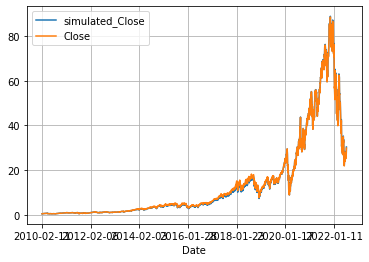

In [37]:
result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

all simulation results

In [40]:
final_result = pysqldf(u"""
    select 
    data1.Date,
    data1.price AS {},
    data1.`Leveraged_price` * {} + {} AS simulated_{},
    data_3x.Close as {}
    from data1
    left join data_3x on data_3x.Date = data1.Date
    """.format(
    ETF,
    reg.coef_[0],
    reg.intercept_,
    ETF_3x,
    ETF_3x
    ))

<AxesSubplot:xlabel='Date'>

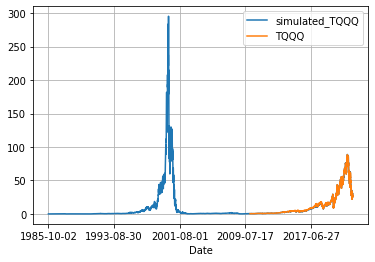

In [42]:
final_result.plot(x ='Date', y=[
    'simulated_{}'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

In [45]:
final_result.to_excel(
    simulation_result_exls_file,
    index = False,
    )

END